```
random profile에 대하여 학습하는 stochastic PPO agent
profile 길이가 1800초 넘어갈때도 있음
buffer를 두번 호출하면 에러남

log_dir 추가
wltp profile로만 학습해봄

state 차원 축소
reward 계수 조정
state 값 1근처로

buffer 내에서 normalization 해야할수도

tanh 모두 제거

SoC reward만
state*1000
reward/10000

```

# Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0806

/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0806


In [ ]:
!pip install fmpy

In [ ]:
import os
import sys
from glob import glob
from fmpy import read_model_description, extract
from fmpy.fmi2 import FMU2Slave
from fmpy.util import plot_result, download_test_file
import numpy as np
import pandas as pd
import shutil
import matplotlib.pyplot as plt
import random
import argparse
from collections import deque
from tqdm import tqdm
import scipy.signal
import time
import random
import copy

In [ ]:
cwd = os.getcwd()
print(cwd)

/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0806


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, optim
from torch.distributions.normal import Normal
from torch import FloatTensor as FT

import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms
from torch.autograd import Variable
from torch.utils.data import Dataset, TensorDataset, DataLoader

In [ ]:
# GPU 준비
USE_CUDA = torch.cuda.is_available()
dev = torch.device("cuda:0" if USE_CUDA else "cpu")
print("Using Device:", dev)
torch.cuda.empty_cache()
#dev = torch.device("cpu")

Using Device: cpu


# HEV Environment

In [ ]:
# data_dir = "D:\RDEDB_Stat_TripData\TripDataTintrWithExh"
# def make_profile():
#     file_names = []
#     folder_names = glob(data_dir + "\\*GI")
#     for folder_name in folder_names:
#         for file_name in glob(folder_name+"/*.csv"):
#             file_names.append(file_name)
#     files_num = len(file_names)
#     done =True
#     while done:
#         file_num = random.randint(0, files_num)
#         file_name = file_names[file_num]
#         profile = np.array(pd.read_csv(file_name)['vehSpeed'])
#         done = profile.shape[0]==0
#     print(f'Profile Name : {file_name},\nProfile Time : {profile.shape[0]}')
#     return profile
# profile = make_profile()
# profile.shape

In [ ]:
# fmu_filename = 'HEV_TMED_Simulator_Rearrange_230213_linux.fmu'
fmu_filename = 'HEV_TMED_Simulator_Rearrange_230711_linux.fmu'
start_time = 0.0
stop_time = 1800.0
step_size = 0.01
soc_init = 67
profile_name = 'wltp_1Hz.csv'
# with open("wltp_vehicle_speed_profile_real.csv") as file_name:
#     vehicle_speed_profile = np.loadtxt(file_name, delimiter=",")

In [ ]:
class HEV:
    def __init__(self, fmu_filename, test=False, start_time=0.0, step_size=0.01, SoC_coeff=5, BSFC_coeff=1, reward_coeff=0.01, state_coeff=1000):
        self.fmu_filename = fmu_filename
        self.vrs = {}
        self.start_time = start_time
        self.step_size = step_size
        self.SoC_coeff = SoC_coeff
        self.BSFC_coeff = BSFC_coeff
        self.reward_coeff = reward_coeff
        self.state_coeff = state_coeff
        self.time = self.start_time
        self.test = test
        if self.test:
            self.vehicle_speed_profile =  np.array(pd.read_csv(profile_name))[:,0]
            self.soc_init = 67/100
            print(f'Initial SoC : {self.soc_init*100}')
        else:
            self.vehicle_speed_profile = make_profile()
            self.soc_init = random.uniform(57, 77)/100
            print(f'Initial SoC : {self.soc_init*100}')
        self.time_profile = np.arange(self.vehicle_speed_profile.shape[0])
        self.stop_time = self.vehicle_speed_profile.shape[0] - 1
        self.state_init = np.array([self.soc_init, 0, 0, 0, 0, 0, 0]).reshape(1,-1)
        self.soc_base = 67/100
        self.state = self.state_init
        self.action_upper_bound = 20000
        self.action_lower_bound = -20000
        #self.action_space = [[13500, 2000], [500, 2000], [13500, -15000], [500, -15000]]
        self.obssize = len(self.state[0])
        self.actsize = 2
        model_description = read_model_description(self.fmu_filename)
        for variable in model_description.modelVariables:
            self.vrs[variable.name] = variable.valueReference
        unzipdir = extract(fmu_filename)
        self.fmu = FMU2Slave(guid=model_description.guid,
                       unzipDirectory=unzipdir,
                       modelIdentifier=model_description.coSimulation.modelIdentifier,
                       instanceName='instance1')

    def step(self, action):
        #a = self.action_space[action]
#         action = action*self.action_upper_bound
        action = torch.clamp(action, -1.0, 1.0)[0]
        a1 = action[0]*self.action_upper_bound
        a2 = action[0]*self.action_upper_bound
        a3 = self.soc_init*100
        a4 = action[1]/2 + 1
        instant_veh_speed = np.interp(self.time, self.time_profile, self.vehicle_speed_profile)
        self.fmu.setReal([self.vr_input1, self.vr_input2, self.vr_input3, self.vr_input4, self.vr_input5], [instant_veh_speed, a1, a2, a3, a4]) #input variable, input key(13500 2000)
        self.fmu.doStep(currentCommunicationPoint=self.time, communicationStepSize=self.step_size)
#         [output1, output2, output3, output4, output5, output6, output7] = self.fmu.getReal([self.vr_output1,self.vr_output2, self.vr_output3, self.vr_output4, self.vr_output5, self.vr_output6, self.vr_output7])
#         self.state = [output1, output2, output3, output4, output5, output6, output7]
        state = np.array(self.fmu.getReal(np.arange(35)))
#         state_column = np.array([self.vrs['Bat_SOC'], self.vrs['nEngOn'], self.vrs['PT_tqTmInDmd_Nm_P2'], self.vrs['ObEng_nEng_Rpm'], self.vrs['TrEtp_tqEngMAF_Nm'], self.vrs['TrP0_tqP0_Nm'], self.vrs['TrP2_tqP2_Nm'], self.vrs['Driver_sVeh_kph'], self.vrs['BSFC_g_kWh[1]']])
        state_column = np.array([self.vrs['Bat_SOC'], self.vrs['BSFC_g_kWh[1]'], self.vrs['ObEng_nEng_Rpm'], self.vrs['TrEtp_tqEngMAF_Nm'], self.vrs['TrP0_tqP0_Nm'], self.vrs['TrP2_tqP2_Nm'], self.vrs['Driver_sVeh_kph']])
        self.state = state[state_column]
        soc = state[self.vrs['Bat_SOC']]/100
        BSFC = state[self.vrs['BSFC_g_kWh[1]']]/300
        engine_speed = state[self.vrs['ObEng_nEng_Rpm']]/2500
        engine_torque = state[self.vrs['TrEtp_tqEngMAF_Nm']]/250
        P0_torque = state[self.vrs['TrP0_tqP0_Nm']]/30
        P2_torque = state[self.vrs['TrP2_tqP2_Nm']]/200
        vehicle_speed = state[self.vrs['Driver_sVeh_kph']]/100
        self.state = np.array([soc, BSFC, engine_speed, engine_torque, P0_torque, P2_torque, vehicle_speed])

        reward = - self.SoC_coeff * (self.soc_base - soc) ** 2 - self.BSFC_coeff * BSFC
        reward = self.reward_coeff * reward
        is_done = lambda time: time >= self.stop_time
        info = state[np.array([self.vrs['Bat_SOC'], self.vrs['nEngOn'], self.vrs['PT_tqTmInDmd_Nm_P2'], self.vrs['ObEng_nEng_Rpm'], self.vrs['TrEtp_tqEngMAF_Nm'], self.vrs['TrP0_tqP0_Nm'], self.vrs['TrP2_tqP2_Nm'], self.vrs['Driver_sVeh_kph'], self.vrs['BSFC_g_kWh[1]']])]
        self.time += self.step_size
        return self.state.reshape(1,-1)*self.state_coeff, reward, is_done(self.time), info

    def reset(self):
        self.fmu.instantiate()
        self.fmu.setupExperiment(startTime=self.start_time)
        self.fmu.enterInitializationMode()
        self.fmu.exitInitializationMode()
        self.state = self.state_init
        self.time = self.start_time
        if self.test:
            self.vehicle_speed_profile =  np.array(pd.read_csv(profile_name))[:,0]
            self.soc_init = 67/100
            print(f'Initial SoC : {self.soc_init*100}')
        else:
            self.vehicle_speed_profile = make_profile()
            self.soc_init = random.uniform(57, 77)/100
            print(f'Initial SoC : {self.soc_init*100}')
        self.time_profile = np.arange(self.vehicle_speed_profile.shape[0])
        self.stop_time = self.vehicle_speed_profile.shape[0] - 1

        self.vr_input1 = self.vrs['Driver_sVeh_Target_kph']
        self.vr_input2 = self.vrs['Engine_on_line']
        self.vr_input3 = self.vrs['Engine_off_line']
        self.vr_input4 = self.vrs['soc_init']
        self.vr_input5 = self.vrs['Engine_OOL']
        self.vr_output1 = self.vrs['TgMod_fPt']
        self.vr_output2 = self.vrs['P2_wElec_W']
        self.vr_output3 = self.vrs['P4_wElec_W']
        self.vr_output4 = self.vrs['ObP2_wElecBIntv_W']
        self.vr_output5 = self.vrs['EV_on_line']
        self.vr_output6 = self.vrs['EV_off_line']
        self.vr_output7 = self.vrs['Bat_SOC']
        self.vr_output8 = self.vrs['PT_tqTmInDmd_Nm_P2']
        self.vr_output9 = self.vrs['P0_wElec_W']
        self.vr_output10 = self.vrs['Pwr_Aux_W']
        self.vr_output11 = self.vrs['ObEng_nEng_Rpm']
        self.vr_output12 = self.vrs['TrEtp_tqEngMAF_Nm']
        self.vr_output13 = self.vrs['rpm_P0']
        self.vr_output14 = self.vrs['TM_F_nTmIn_rpm']
        self.vr_output15 = self.vrs['TM_R_nTmIn_rpm']
        self.vr_output16 = self.vrs['eBat_kWh']
        self.vr_output17 = self.vrs['nEngOn']
        self.vr_output18 = self.vrs['TrP0_tqP0_Nm']
        self.vr_output19 = self.vrs['TrP2_tqP2_Nm']
        self.vr_output20 = self.vrs['TrP4_tqP4_Nm']
        self.vr_output21 = self.vrs['TCU_F_fCurGe']
        self.vr_output22 = self.vrs['TCU_F_fTarGe']
        self.vr_output23 = self.vrs['Driver_sVeh_kph']
        self.vr_output24 = self.vrs['Eng_eff_avg']
        self.vr_output25 = self.vrs['TM_F_P0P2_eff_avg']
        self.vr_output26 = self.vrs['TM_F_P0P4_eff_avg']
        self.vr_output27 = self.vrs['BSFC_g_kWh[1]']
        self.vr_output28 = self.vrs['BSFC_g_kWh[2]']
        self.vr_output29 = self.vrs['BSFC_g_kWh[3]']

        return self.state.reshape(1,-1)

# Agent

In [ ]:
class Generate_Dataset(torch.utils.data.Dataset):
    def __init__(self, dev, buffer1, buffer2, buffer3, buffer4, buffer5):
        self.buffer1 = FT(buffer1).clone().detach().to(dev)
        self.buffer2 = FT(buffer2).clone().detach().to(dev)
        self.buffer3 = FT(buffer3).clone().detach().to(dev)
        self.buffer4 = FT(buffer4).clone().detach().to(dev)
        self.buffer5 = FT(buffer5).clone().detach().to(dev)
    def __len__(self):
        return len(self.buffer1)
    def __getitem__(self, idx):
        buffer1 = self.buffer1[idx]
        buffer2 = self.buffer2[idx]
        buffer3 = self.buffer3[idx]
        buffer4 = self.buffer4[idx]
        buffer5 = self.buffer5[idx]
        return buffer1, buffer2, buffer3, buffer4, buffer5

def discounted_cumulative_sums(x, discount):
    # Discounted cumulative sums of vectors for computing rewards-to-go and advantage estimates
    return torch.flip(torch.tensor(scipy.signal.lfilter([1], [1, float(-discount)], torch.flip(x, dims=[0]).detach().numpy(), axis=0)), dims=[0])

class Buffer:
    # Buffer for storing trajectories
    def __init__(self, observation_dimensions, action_dimensions, size, gamma=0.99, lam=0.95):
        # Buffer initialization
        self.observation_buffer = torch.zeros((size, observation_dimensions), dtype=torch.float32)
        self.action_buffer = torch.zeros((size, action_dimensions), dtype=torch.float32)
        self.advantage_buffer = torch.zeros(size, dtype=torch.float32)
        self.reward_buffer = torch.zeros(size, dtype=torch.float32)
        self.return_buffer = torch.zeros(size, dtype=torch.float32)
        self.value_buffer = torch.zeros(size, dtype=torch.float32)
        self.logprobability_buffer = torch.zeros((size, action_dimensions), dtype=torch.float32)
        self.gamma, self.lam = gamma, lam
        self.pointer, self.trajectory_start_index = 0, 0

    def store(self, observation, action, reward, value, logprobability):
        # Append one step of agent-environment interaction
        self.observation_buffer[self.pointer] = FT(observation)
        self.action_buffer[self.pointer] = FT(action)
        self.reward_buffer[self.pointer] = FT([reward])
        self.value_buffer[self.pointer] = FT(value)
        self.logprobability_buffer[self.pointer] = FT(logprobability)
        self.pointer += 1

    def finish_trajectory(self, last_value=0):
        # Finish the trajectory by computing advantage estimates and rewards-to-go
        path_slice = slice(self.trajectory_start_index, self.pointer)
        rewards = torch.cat([self.reward_buffer[path_slice], torch.tensor([last_value])])
        values = torch.cat([self.value_buffer[path_slice], torch.tensor([last_value])])

        deltas = rewards[:-1] + self.gamma * values[1:] - values[:-1]

        self.advantage_buffer[path_slice] = discounted_cumulative_sums(
            deltas, self.gamma * self.lam
        )
        self.return_buffer[path_slice] = discounted_cumulative_sums(
            rewards, self.gamma
        )[:-1]

#         self.trajectory_start_index = self.pointer

    def get(self):
        # Get all data of the buffer and normalize the advantages
        self.path_slice = slice(self.trajectory_start_index, self.pointer)
        path_slice = slice(self.trajectory_start_index, self.pointer)
        self.pointer, self.trajectory_start_index = 0, 0
#         advantage_mean, advantage_std = (
#             torch.mean(self.advantage_buffer[path_slice]),
#             torch.std(self.advantage_buffer[path_slice]),
#         )
#         self.advantage_buffer[path_slice] = (self.advantage_buffer[path_slice] - advantage_mean) / advantage_std
        # return_mean, return_std = (
        #     torch.mean(self.return_buffer[path_slice]),
        #     torch.std(self.return_buffer[path_slice]),
        # )
        # self.return_buffer[path_slice] = (self.return_buffer[path_slice] - return_mean) / return_std
        return (
            self.observation_buffer[path_slice],
            self.action_buffer[path_slice],
            self.advantage_buffer[path_slice],
            self.return_buffer[path_slice],
            self.logprobability_buffer[path_slice],
            self.reward_buffer[path_slice]
        )


class ActorCritic(nn.Module):
    def __init__(self, num_states, num_actions):
        super(ActorCritic, self).__init__()
        self.actorlayer = nn.Sequential(
            nn.Linear(num_states, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64,32),
            nn.Tanh(),)

        self.criticlayer = nn.Sequential(
            nn.Linear(num_states, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64,32),
            nn.Tanh(),)
        self.layer2 = nn.Linear(32, num_actions)
        self.layer3 = nn.Linear(32, num_actions)
        self.layer4 = nn.Linear(32, 1)

    def forward(self, states):
        x = self.actorlayer(states)
        x2 = self.criticlayer(states)
        mu = self.layer2(x)
        mu = torch.tanh(mu)
        std = self.layer3(x)
        std = torch.exp(torch.tanh(std)*11-9)
#         std = torch.log(1 + torch.exp(std))
        #std = torch.tanh(std)
        #std = self.softplus(std)
        value = self.layer4(x2)
        # value = torch.tanh(value)
        return [mu, std], value


class PPO_agent(nn.Module):      # PPO agent

    def __init__(self, e, log_dir, gamma=0.99, clip_ratio=0.2, actor_lr = 3e-4, critic_lr = 1e-3, alpha=0.01):
        super(PPO_agent, self).__init__()
        # Hyperparameters of the PPO algorithm
        self.dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.log_dir = log_dir
        self.steps_per_episode = 800000
        self.episodes = 100
        self.EPOCH = 1
        self.gamma = gamma
        self.clip_ratio = clip_ratio
        self.actor_lr = actor_lr
        self.critic_lr = critic_lr
        self.alpha = alpha
        self.r_sum = 0
        self.loss = []

        self.lam = 0.97
        self.start_episode = 0
        self.pretrained_episode = 0

        self.env = e
        self.observation_dimensions = self.env.obssize
        self.num_actions = self.env.actsize

        self.buffer = Buffer(self.observation_dimensions, self.num_actions, self.steps_per_episode)
        self.actorcritic = ActorCritic(self.observation_dimensions, self.num_actions).to(self.dev)
        actorparam = list(self.actorcritic.actorlayer.parameters()) + list(self.actorcritic.layer2.parameters()) + list(self.actorcritic.layer3.parameters())
        self.optimizer_actor = torch.optim.Adam(actorparam,lr=self.actor_lr)
        criticparam = list(self.actorcritic.criticlayer.parameters()) + list(self.actorcritic.layer4.parameters())
        self.optimizer_critic = torch.optim.Adam(criticparam,lr=self.critic_lr)
        self.actorcritic_clone = ActorCritic(self.observation_dimensions, self.num_actions)

        # self.scheduler = optim.lr_scheduler.LambdaLR(optimizer=self.optimizer_actor,
        #                                              lr_lambda=lambda epoch: 0.99 ** (epoch+self.start_epoch),
        #                                              last_epoch=-1,
        #                                              verbose=False)
        print("The agent has been created..")
    # Define the action sampling function
    def sample_continuous_action(self, observation):
        [mu, std], value = self.actorcritic(FT(observation.reshape(1,-1)).to(self.dev))
        action_dist = Normal(loc=mu, scale=std)
        action = action_dist.sample()
        action = torch.clamp(action, -1.0, 1.0)[0]

        return action.cpu()

    def sample_action(self, observation):
        [mu, std], value = self.actorcritic(FT(observation.reshape(1,-1)).to(self.dev))
#         action = torch.clamp(mu, -1.0, 1.0)[0]

        return mu.cpu().detach()


    def update(self,
               observation_buffer_cpu, action_buffer_cpu, advantage_buffer_cpu, return_buffer_cpu, logprobability_buffer_cpu):

        train_ds = Generate_Dataset(self.dev, observation_buffer_cpu, action_buffer_cpu, advantage_buffer_cpu, return_buffer_cpu, logprobability_buffer_cpu)
        train_dl = DataLoader(train_ds, batch_size=256, shuffle=True)

        for epoch in range(self.EPOCH):
            loss_actor = 0
            loss_critic = 0
            loss_entropy = 0
            with tqdm(train_dl, unit = 'batch') as tepoch:
                for observation_buffer, action_buffer, advantage_buffer, return_buffer, logprobability_buffer in tepoch:
                    # Calculate new probabilities and ratio
                    [mu, std], new_values = self.actorcritic(observation_buffer)

                    new_action_dist = Normal(mu, std)
                    new_probs = new_action_dist.log_prob(action_buffer)

                    ratio = new_probs - logprobability_buffer
                    ratio = torch.clamp(ratio, max=50)
                    ratio = torch.exp(ratio).mean(1)

                    # Calculate surrogate loss
                    unclipped_obj = ratio * advantage_buffer
                    clipped_obj = torch.clamp(ratio, 1-self.clip_ratio, 1+self.clip_ratio) * advantage_buffer
                    actor_loss = -torch.min(unclipped_obj, clipped_obj).sum()

                    # Calculate value loss
                    critic_loss = F.mse_loss(new_values, return_buffer.unsqueeze(1))

                    # Calculate entropy bonus
                    entropy_bonus = new_action_dist.entropy().sum()

                    # Calculate total loss
                    total_loss = actor_loss - self.alpha*entropy_bonus

                    # Calculate gradients and update weights
                    self.optimizer_actor.zero_grad()
                    total_loss.backward()
                    self.optimizer_actor.step()

                    self.optimizer_critic.zero_grad()
                    critic_loss.backward()
                    self.optimizer_critic.step()

                    loss_actor += actor_loss / (self.steps_per_episode/256)
                    loss_critic += critic_loss / (self.steps_per_episode/256)
                    loss_entropy += entropy_bonus / (self.steps_per_episode/256)
                    tepoch.set_description(f"Epoch {epoch+1}")
                    tepoch.set_postfix(loss_actor=loss_actor.item(), loss_critic=loss_critic.item(), loss_entropy=loss_entropy.item())
                    #                   self.loss.append([total_loss.item(), actor_loss.item(), critic_loss.item(), -self.alpha*entropy_bonus.item()])
                  # self.scheduler.step()
        plt.plot(new_probs.detach().cpu())
        plt.plot(logprobability_buffer.detach().cpu())
        plt.show()
    def load_pretrain(self, EPISODE):
        print("Loading pretrained model..")
        self.pretrained_episode = EPISODE
        self.start_episode = EPISODE
        self.actorcritic = torch.load(os.getcwd()+f'/model/2DPPO_pretrain/PPO_actorcritic_pretrain_{self.pretrained_spisode}episode.pt')

    def load_weights(self, EPISODE):
        print("Loading existing model..")
        self.start_episode = EPISODE
        self.actorcritic = torch.load(os.getcwd() + self.log_dir + f'/PPO_actorcritic_{self.start_episode}episode.pt')    # load policy

    def history(self):
        print("making episode history..")
        self.actorcritic.eval()
        self.env = HEV(fmu_filename, test=True, start_time=0.0, step_size = 0.01)
        observation = self.env.reset()
        done = False
        cum_reward = 0.0
        a_record = []
        r_record = []
        s_record = []
        while not done:
            observation = observation.reshape(1,-1)
            action = self.sample_action(observation)
            observation_new, reward, done, info = self.env.step(action)
            cum_reward += reward
            a_record.append(np.array(action))
            r_record.append(reward)
            s_record.append(info)
            observation = observation_new
        print(f"total reward: {cum_reward}")
        self.r_sum = cum_reward
        return np.squeeze(a_record), np.array(r_record), np.squeeze(s_record)

    def train(self, EPISODES=10):
        self.episodes = EPISODES
        self.r_record = []
        sum_return = 0
        sum_length = 0
        num_episodes = 0
        print("Start training..")
        self.actorcritic.train()

        for episode in range(self.episodes):
            observation, episode_return, episode_length = self.env.reset(), 0, 0
            start = time.time()

            self.steps_per_episode = int(env.stop_time / env.step_size)
            self.actorcritic_clone = copy.deepcopy(self.actorcritic).cpu()

            for t in range(self.steps_per_episode):

                [mu, std], value_t = self.actorcritic_clone(FT(observation.reshape(1,-1)))
                action_dist = Normal(loc=mu, scale=std)
                action = action_dist.sample()
#                 action = torch.clamp(action, -1.0, 1.0)[0]
                logprobability_t = action_dist.log_prob(action)

                observation_new, reward, done, _ = self.env.step(action)

                episode_return += reward
                episode_length += 1

                self.buffer.store(observation, action, reward, value_t, logprobability_t)

                observation = observation_new

                terminal = done
                if terminal or (t == self.steps_per_episode - 1):
                    if done:
                        last_value = 0
                    else:
                        [_, _], last_value = self.actorcritic_clone(FT(observation.reshape(1,-1)))
                    self.buffer.finish_trajectory(last_value)
                    sum_return += episode_return
                    sum_length += episode_length
                    num_episodes += 1

            (
                observation_buffer,
                action_buffer,
                advantage_buffer,
                return_buffer,
                logprobability_buffer,
                reward_buffer
            ) = self.buffer.get()

            self.data = [observation_buffer, action_buffer, advantage_buffer, return_buffer, logprobability_buffer, reward_buffer]
            self.update(
                observation_buffer, action_buffer, advantage_buffer, return_buffer, logprobability_buffer
                )

            print(
                " Episode: "+str(self.start_episode + episode + 1)+". Mean Return: "+str(sum_return / sum_length)+". Mean Length: "+str(sum_length / num_episodes)
            )
            self.r_record.append(sum_return/sum_length)
#             print(self.loss[episode])
            print(time.time()-start)
            torch.save(self.actorcritic, os.getcwd()+ self.log_dir + f'/PPO_actorcritic_{self.start_episode+episode+1}episode.pt')
        return self.r_record, observation_buffer, action_buffer, advantage_buffer, return_buffer, logprobability_buffer, reward_buffer

In [ ]:
env = HEV(fmu_filename, test=True, start_time=0.0, step_size = 0.01, SoC_coeff=5, BSFC_coeff=0, reward_coeff=1, state_coeff=1)
log_dir = '/model/WLTP_trained'
state = env.reset()
agent = PPO_agent(env, log_dir, gamma=0.99, clip_ratio=0.2, actor_lr=1e-3, critic_lr=1e-3, alpha=0.01)

Initial SoC : 67.0
Initial SoC : 67.0
The agent has been created..


Start training..
Initial SoC : 67.0


Epoch 1: 100%|██████████| 704/704 [00:15<00:00, 44.25batch/s, loss_actor=1.1e+3, loss_critic=520, loss_entropy=433]


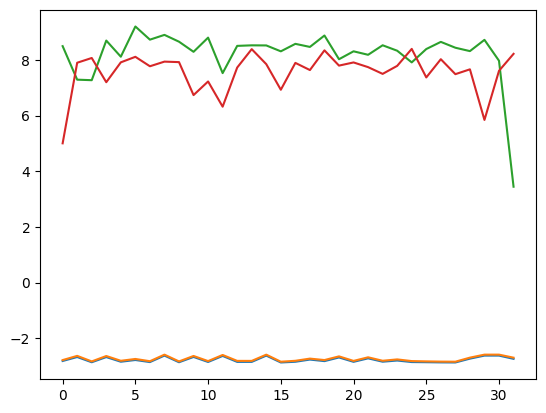

 Episode: 1. Mean Return: -0.320345313086206. Mean Length: 180000.0
261.88951420783997
Initial SoC : 67.0


In [ ]:
#training agent
episode = 20
# agent.load_weights(20)
AUC, observation_buffer, action_buffer, advantage_buffer, return_buffer, logprobability_buffer, reward_buffer = agent.train(20)

plt.plot(AUC, label = 'stochastic PPO agent')
plt.legend()
plt.xlabel('episodes')
plt.ylabel('total reward')
plt.title('HEV')
plt.show()

In [ ]:
agent.loss

In [ ]:
# observation_buffer = observation_buffer.clone().detach().to(agent.dev)
# action_buffer = action_buffer.clone().detach().to(agent.dev)
# advantage_buffer = advantage_buffer.clone().detach().to(agent.dev)
# return_buffer = return_buffer.clone().detach().to(agent.dev)
# logprobability_buffer = logprobability_buffer.clone().detach().to(agent.dev)
# # Calculate new probabilities and ratio
# [mu, std], new_values = agent.actorcritic(observation_buffer)
# # [mu, std], new_values = [mu.cpu(), std.cpu()], new_values.cpu()


# new_action_dist = Normal(mu, std)
# new_probs = new_action_dist.log_prob(action_buffer)
# ratio = torch.exp(new_probs - logprobability_buffer).mean(1)

# # Calculate surrogate loss
# unclipped_obj = ratio * advantage_buffer
# clipped_obj = torch.clamp(ratio, 1-agent.clip_ratio, 1+agent.clip_ratio) * advantage_buffer
# actor_loss = -torch.min(unclipped_obj, clipped_obj).sum()

# # Calculate value loss
# critic_loss = F.mse_loss(new_values, return_buffer.unsqueeze(1))

# # Calculate entropy bonus
# entropy_bonus = new_action_dist.entropy().sum()

# # Calculate total loss
# total_loss = actor_loss + critic_loss - agent.alpha*entropy_bonus
# print(total_loss.item(), actor_loss.item(), critic_loss.item(), -agent.alpha*entropy_bonus.item())

In [ ]:
# plt.plot(new_values.detach().cpu(), label='new_values')

In [ ]:
# plt.plot(new_values.detach().cpu(), label='new_values')
# plt.plot(return_buffer.detach().cpu(), label='return_buffer')
# plt.legend(loc='best')
# plt.show()

In [ ]:
# agent.load_weights(20)

In [ ]:
a_record, r_record, s_record = agent.history()

In [ ]:
plt.plot(r_record, label='PPO')
plt.legend(loc='best')
plt.xlabel('time(0.01sec)')
plt.ylabel('reward')
plt.title(f'Reward for WLTP Cycle')
plt.show()

In [ ]:
plt.plot(a_record)

In [ ]:
plt.plot(a_record[:,0], label='Engine Line (PPO)')
plt.axhline(y=13.5/20, color='r', linewidth=1, label='Engine on Line (Rule-Based)')
plt.axhline(y=2/20, color='r', linewidth=1, label='Engine off Line (Rule-Based)')
plt.legend(loc='best')
plt.xlabel('time (0.01sec)')
plt.ylabel('action')
plt.title(f'Instant Engine Line for WLTP Cycle')
plt.show()

In [ ]:
plt.plot(a_record[:,1], label='OOL (PPO)')
plt.axhline(y=0, color='r', linewidth=1, label='OOL (Rule-Based)')
plt.legend(loc='best')
plt.xlabel('time (0.01sec)')
plt.ylabel('action')
plt.title(f'Instant OOL for WLTP Cycle')
plt.show()

In [ ]:
SoC = s_record[:,0]
plt.plot(SoC, label='PPO')
plt.axhline(y=67, color='r', linewidth=1, label='Initial SoC (67%)')
plt.legend(loc='best')
plt.xlabel('time (0.01sec)')
plt.ylabel('SoC (%)')
plt.title(f'Instant SoC for WLTP Cycle')
plt.show()

In [ ]:
bsfc = s_record[:,-1]
plt.plot(bsfc, label='BSFC')
plt.legend(loc='best')
plt.xlabel('time (0.01sec)')
plt.ylabel('BSFC (g/kW)')
plt.title(f'Instant BSFC for WLTP Cycle')
plt.show()

In [ ]:
engine_speed = s_record[:,3]
engine_torque = s_record[:,4]
plt.scatter(engine_speed, engine_torque, s=0.1, label='PPO')
plt.legend(loc='best')
plt.xlabel('Engine speed (rpm)')
plt.ylabel('Engine torque (Nm)')
plt.title('Engine Operating Points for WLTP Cycle')
plt.show()